# **<h1 align="center">Data Mining 2024-25</h3>**
## **<h3 align="center">Customer Segmentation - ABCDEats Inc.</h3>**
### **<h3 align="center">Merging Perpectives</h3>**


**Group 10 members:**<br>Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Marco Galão  - r20201545@novaims.unl.pt - r20201545<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub  - 20240505@novaims.unl.pt - 20240505<br>

<a id = "toc"></a>

# Table of Contents

* [1. Import the Libraries](#import_libraries)
* [2. Import the Dataset](#import_dataset)
* [3. Normalization](#normalization)
* [4. RFM](#rfm)
* [5. Merging Different Perpectives](#merge_perpectives)
    * [5.1. Contingency Table](#contigency_table)
    * [5.2. Manual Merging of Clusters](#manual_merg_clus)
    * [5.3. Using Hierarchical Clustering](#hierarchical_clust)
* [6. Cluster Analysis ](#cluster_analysis)
* [7. Association Rules](#association_rules)




#NOTE: I DON'T REMEMBER EXACTLY THE HYBRID APPROACHES TO DONT FOLLOW BY THE NAME, IF ITS WRONG JUST CORRECT:)





---

In this notebook, we will merge the segmentation results from two distinct perspectives: **taste** and **purchasing habits**. These two perspectives represent different customer behaviors and preferences, and combining them will allow us to develop a more holistic understanding of our customers. 

We will begin by merging the clusters derived from taste features with those from purchasing habits, ensuring that we create a unified dataset with both segmentation labels. Once the merge is completed, we will explore the resulting segments and evaluate their characteristics.

After merging, we will apply association rule mining techniques to discover relationships between the different customer segments and their behaviors. We will also perform additional analyses, such as clustering validation and examining potential patterns within the merged segments. This process will help us uncover hidden insights and improve our segmentation strategy.

---

# 1. Import the Libraries <a class="anchor" id="import_libraries"></a>
[Back to ToC](#toc)<br>

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from matplotlib.patches import RegularPolygon, Ellipse
import json

#To perform Clustering Algorithms
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import dendrogram, linkage
from minisom import MiniSom


import warnings
warnings.filterwarnings("ignore")

#Importing the functions created in main.py
from main import *
import importlib
imported_module = importlib.import_module("main")
importlib.reload(imported_module)

<module 'main' from 'c:\\Users\\xandg\\Ambiente de Trabalho\\IMS\\3rd year\\1st Semester\\Capstone Project\\OpenAI\\Capstone-Project\\CustomerSegmentationDataMining\\deliverables\\main.py'>

# 2. Import the Dataset <a class="anchor" id="import_dataset"></a>
[Back to ToC](#toc)<br>

In this section, we import the preprocessed dataset and set the customer_id as the index column. Also, check the first and last 5 rows of the dataset.

In [56]:
### CHANGE THIS USING THE DATASET WITH LABELS FROM PART '2 AND 03 CLUSTERING
df_clustering = pd.read_csv("../Data/df_outliers.csv", index_col="customer_id")
df_clustering.head().T

customer_id,1b8f824d5e,f6d1b2ba63,180c632ed8,4eb37a6705,6aef2b6726
customer_region,2360,4660,4660,4660,8670
customer_age,18,38,26,20,40
vendor_count,2,1,2,2,2
product_count,5,2,3,5,2
chain_orders,1,2,1,0,0
...,...,...,...,...,...
prop_cui_other,0.0,0.0,0.0,0.0,0.0
prop_cui_street food / snacks,0.0,0.0,0.0,0.0,0.0
prop_cui_thai,0.0,0.0,0.0,0.0,0.0
generation_encoded,4,3,3,4,3


# 3. Normalization <a class="anchor" id="normalization"></a>
[Back to ToC](#toc)<br>


## ??? IDK IF THIS IS NEEDED AT THIS STAGE

Let's open the json file witth the categories.

In [57]:
# Load the categories dictionary from the JSON file
with open("categories.json", "r") as file:
    loaded_categories = json.load(file)

print("Categories dictionary has been successfully loaded!")
print(loaded_categories)

Categories dictionary has been successfully loaded!
{'demographics': ['customer_region', 'customer_age', 'city', 'generation_encoded'], 'economic_values': ['avg_order_value', 'customer_age'], 'purchasing_habits': ['first_order', 'chain_orders_prop', 'orders_dawn', 'orders_morning', 'orders_afternoon', 'orders_evening', 'order_recency', 'weekend_to_weekday_ratio'], 'taste': ['prop_cui_cafe', 'prop_cui_chicken dishes', 'prop_cui_chinese', 'prop_cui_indian', 'prop_cui_japanese', 'prop_cui_noodle dishes', 'prop_cui_other', 'prop_cui_street food / snacks', 'prop_cui_thai', 'health_index', 'cui_asian_spending', 'cui_western_spending'], 'categorical': ['last_promo', 'payment_method', 'promo_used', 'city']}


In this notebook, we will focus on clustering from the taste perspective. First, we will select the relevant features and then apply normalization using the `scaled_dataframe` function from `main.py`.

In [58]:
# df_scaled= scaled_dataframe(loaded_categories['purchasing_habits'], df_clustering)

After applying the normalization function to the taste features, we will update the list of taste features by appending "_normalized" to the end of each feature name.

In [59]:
# purchasing_habits_features_normalized = [feature + '_normalized' for feature in loaded_categories['purchasing_habits']]
# purchasing_habits_features_normalized

# 4. RFM <a class="anchor" id="rfm"></a>
[Back to ToC](#toc)<br>

RFM (Recency, Frequency, and Monetary) analysis is a customer segmentation technique that evaluates customer behavior based on three dimensions:
1. **Recency (R)**: How recently a customer made a purchase. More recent activity indicates a higher likelihood of engagement.
   - **Feature**: `order_recency`
   - **Description**: Time since the customer's last order, identifying recent engagement.

2. **Frequency (F)**: How often a customer makes purchases. Frequent customers are more likely to be loyal.
   - **Feature**: `total_orders`
   - **Description**: Total number of orders placed, measuring customer activity.

3. **Monetary (M)**: How much money a customer spends. Higher spending reflects greater customer value.
   - **Feature**: `total_cui_spending`
   - **Description**: Total spending by the customer, reflecting their monetary contribution.

These features allow us to evaluate customer behavior and create actionable clusters to target specific segments for personalized strategies.


In [60]:
rfm_data= df_clustering[['order_recency','total_orders','total_cui_spending']]
rfm_data.head()

,order_recency,total_orders,total_cui_spending
customer_id,,,
1b8f824d5e,0.011111,2,28.88
f6d1b2ba63,0.011111,2,9.20
180c632ed8,0.022222,2,31.56
4eb37a6705,0.022222,2,55.44
6aef2b6726,0.022222,2,24.92


In [61]:
rfm_data.head()

,order_recency,total_orders,total_cui_spending
customer_id,,,
1b8f824d5e,0.011111,2,28.88
f6d1b2ba63,0.011111,2,9.20
180c632ed8,0.022222,2,31.56
4eb37a6705,0.022222,2,55.44
6aef2b6726,0.022222,2,24.92


In [62]:
# Binning Recency, Frequency, and Monetary
M_segmentation = pd.qcut(rfm_data['total_cui_spending'], q=3, labels=False) +1  # High = high value
R_segmentation = pd.qcut(rfm_data['order_recency'], q=3, labels=False) +1  # Recent = better
F_segmentation = pd.qcut(rfm_data['total_orders'], q=3, labels=False) +1  # High = frequent

#Combine into RFM Segmentation
rfm_segmentation = pd.DataFrame(
    {'total_cui_spending': M_segmentation, 'order_recency': R_segmentation, 'total_orders': F_segmentation}
)

#Add Original Values
rfm_segmentation['monetary_value'] = rfm_data['total_cui_spending']
rfm_segmentation['customer_recency'] = rfm_data['order_recency']
rfm_segmentation['customer_frequency'] = rfm_data['total_orders']

# Create RFM Segment Labels
rfm_segmentation['segment'] = (
    rfm_segmentation['order_recency'].astype(str)
    + "-" + rfm_segmentation['total_orders'].astype(str)
    + "-" + rfm_segmentation['total_cui_spending'].astype(str)
)

# Calculate Correlation Matrix
rfm_corr = rfm_segmentation[['monetary_value', 'customer_recency', 'customer_frequency']].corr()

print("Correlation Matrix for RFM Metrics:")
rfm_corr

Correlation Matrix for RFM Metrics:


,monetary_value,customer_recency,customer_frequency
monetary_value,1.000000,0.337318,0.741502
customer_recency,0.337318,1.000000,0.418759
customer_frequency,0.741502,0.418759,1.000000



The correlation matrix between the RFM metrics (Recency, Frequency, and Monetary) reveals the following insights:

- **Monetary and Frequency** have a high correlation (r = 0.74), indicating overlap in the information they provide.
- **Frequency and Recency** have a moderate correlation (r = 0.42).
- **Monetary and Recency** have the lowest correlation (r = 0.34), suggesting they provide more distinct insights.

To simplify the analysis and focus on the most distinct metrics, we will:
1. Remove **Frequency** due to its high correlation with Monetary.
2. Create a bubble plot using only **Recency** and **Monetary**, which represent distinct customer behaviors.

This simplification aligns with the approach used in the previous project, where only the most relevant dimensions were retained for clustering and visualization.

In [64]:
# Adjust column names for aggregation
rfm_segmentation.rename(
    columns={
        'order_recency': 'Recency',
        'total_orders': 'Frequency',
        'total_cui_spending': 'Monetary'
    },
    inplace=True
)

In [65]:
rfm_segmentation.describe()

,Monetary,Recency,Frequency,monetary_value,customer_recency,customer_frequency
count,31236.000000,31236.000000,31236.000000,31236.000000,31236.000000,31236.000000
mean,1.999968,1.987899,1.848668,37.155355,0.708210,4.196664
std,0.816529,0.809845,0.846156,38.513970,0.257466,4.016274
min,1.000000,1.000000,1.000000,0.370000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,13.030000,0.544444,2.000000
50%,2.000000,2.000000,2.000000,24.180000,0.777778,3.000000
75%,3.000000,3.000000,3.000000,45.020000,0.922222,5.000000
max,3.000000,3.000000,3.000000,204.970000,1.000000,20.000000


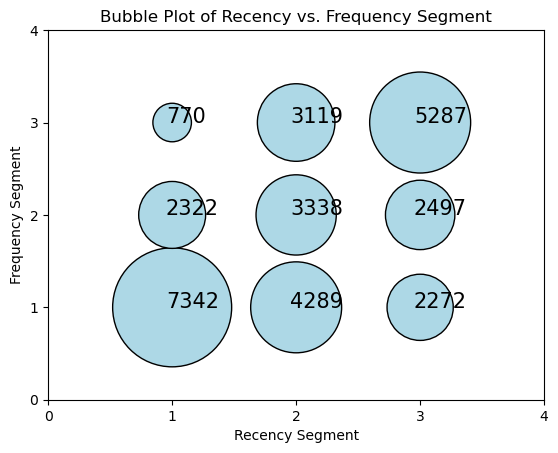

In [66]:
def create_2d_bubble(rf_segment, variable, multiplier, colorbubble):
  '''
  Creates 2-dimensional bubble plot with detailed
  RF segment information.

  Arguments:
  - rf_segment(pd.DataFrame): Dataframe with segments
  data.
  - variable(str): Variable to use as bubble size.
  - multiplier(int): Multiplier to add emphasis to the 
  bubble size.
  - colorbubble(str): color of the bubble plot

  Returns:
  - None, but a plot is shown.
  '''
  fig, ax = plt.subplots()

  # Create the scatter plot 
  # Multiplying by 25 just to see more difference between
  # bubbles
  sc = ax.scatter(rf_segment.Recency, 
            rf_segment.Frequency, 
            s=rf_segment[variable]*multiplier,
            color=colorbubble,
            edgecolors='black')

  # Annotate plot with size
  for i in range(len(rf_segment.Recency)):
    ax.annotate(np.round(rf_segment[variable].iloc[i], 1),
                (rf_segment.Recency.iloc[i]-0.05,
                rf_segment.Frequency.iloc[i]),
                fontsize=15
                )

  plt.title('Bubble Plot of Recency vs. Frequency Segment')
  plt.xlabel('Recency Segment')
  plt.ylabel('Frequency Segment')
  plt.xticks([0,1,2,3,4])
  plt.yticks([0,1,2,3,4])

  plt.show()
  
# Aggregate data for Frequency and Recency groups
segment_size = rfm_segmentation.groupby(['Frequency', 'Recency'], as_index=False).size()
segment_value = rfm_segmentation.groupby(['Frequency', 'Recency'], as_index=False)['monetary_value'].mean()

# Merge size and monetary value
segment_info = segment_size.merge(segment_value, on=['Frequency', 'Recency'])

# Create a bubble plot for size
create_2d_bubble(segment_info, 'size', 1, 'lightblue')  # Bubbles sized by number of customers

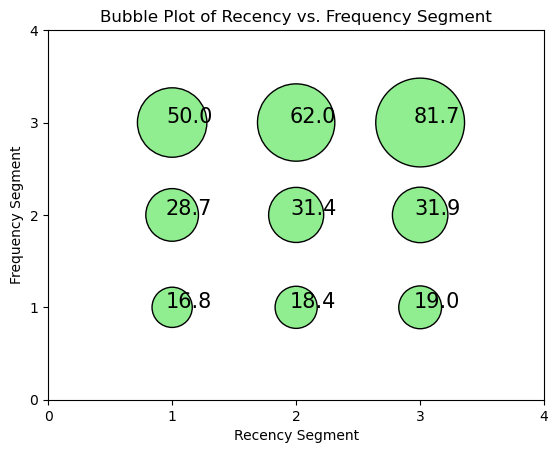

In [69]:
# Create a bubble plot for monetary value
create_2d_bubble(segment_info, 'monetary_value', 50, 'lightgreen')  # Bubbles sized by average monetary value

# 5. Merging Different Perpectives <a class="anchor" id="merge_perpectives"></a>
[Back to ToC](#toc)<br>

## 5.1. Contigency Table <a class="anchor" id="contigency_table"></a>
[Back to 5. Merging Different Perpectives](#merge_perpectives)<br>

In [ ]:
df_clustering['taste_labels'] = taste_labels
df_clustering['purchasing_habits_labels'] = purchasing_habits_labels

In [ ]:
#some code is missing, we still don't have the solutions

In [ ]:
# Count label frequencies (contigency table)
pd.crosstab(df_clustering['taste_labels'],
            df_clustering['purchasing_habits_labels'])

## 5.2. Manual Merging of Clusters <a class="anchor" id="manual_merg_clus"></a>
[Back to 5. Merging Different Perpectives](#merge_perpectives)<br>

In [ ]:
# Get centroids of clusters for both taste and purchasing habits
df_centroids = df_clustering.groupby(['taste_labels', 'purchasing_habits_labels'])[loaded_categories['taste'] + loaded_categories['purchasing_habits']].mean()
df_centroids

In [ ]:
# Clusters with low frequency to be merged:
to_merge = [(3, 2), (3, 0), (2, 2), (0, 2)] ## THIS NEEDS TO CHANGE ACCORDING TO THE PLOT 

# Computing the Euclidean distance matrix between the centroids
centroid_dists = pairwise_distances(df_centroids)

df_dists = pd.DataFrame(
    centroid_dists, 
    columns=df_centroids.index, 
    index=df_centroids.index
)

# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}

for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

# New df for merging
df_clustering_merged = df_clustering.copy()

# Changing the taste_labels and purchasing_habits_labels based on source_target
for source, target in source_target.items():
    mask = (df_clustering_merged['taste_labels'] == source[0]) & (df_clustering_merged['purchasing_habits_labels'] == source[1])
    df_clustering_merged.loc[mask, 'taste_labels'] = target[0]
    df_clustering_merged.loc[mask, 'purchasing_habits_labels'] = target[1]

# New contingency table
pd.crosstab(df_clustering_merged['taste_labels'], df_clustering_merged['purchasing_habits_labels'])

# Original contingency table
pd.crosstab(df_clustering['taste_labels'], df_clustering['purchasing_habits_labels'])

## 5.3. Using Hierarchical Clustering <a class="anchor" id="hierarchical_clust"></a>
[Back to 5. Merging Different Perpectives](#merge_perpectives)<br>

In [ ]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(linkage=linkage, metric='euclidean', distance_threshold=0, n_clusters=None)

hclust_labels = hclust.fit_predict(df_centroids)

# Create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# The linkage matrix
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11, 5))
y_threshold = 2.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()


In [ ]:
# Re-running the Hierarchical clustering based on the correct number of clusters ###NEED TO CHANGE THIS
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=7)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

# Mapping the hierarchical clusters on the centroids to the observations
df_clustering_merged['merged_labels'] = df_clustering_merged.apply(
    lambda row: cluster_mapper[
        (row['taste_labels'], row['purchasing_habits_labels'])
    ], axis=1
)

In [ ]:
# Merged cluster centroids
df_clustering_merged.groupby('merged_labels').mean(numeric_only=True)[loaded_categories['taste'] + loaded_categories['purchasing_habits']]


In [ ]:
# Getting size of each final cluster
df_counts = df_clustering_merged.groupby('merged_labels').size().to_frame()

# Getting the product and behavior labels
df_counts = df_counts.rename({v: k for k, v in cluster_mapper.items()}).reset_index()

# Mapping behavior_labels and product_labels
df_counts['taste_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['purchasing_habits_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

# Displaying the final counts pivoted
df_counts.pivot(values=0, index='taste_labels', columns='purchasing_habits_labels')


# 6. Cluster Analysis <a class="anchor" id="cluster_analysis"></a>
[Back to ToC](#toc)<br>

In [ ]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass df with label columns of one or multiple clustering labels.
    Then specify these label columns to perform the cluster profile according to them.
    """
    
    if compare_titles is None:
        compare_titles = [""] * len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df to keep only relevant columns
        drop_cols = [i for i in label_columns if i != label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:, [0, 1]]
        counts.columns = [label, "counts"]
        
        # Plotting parallel coordinates for cluster centroids
        pd.plotting.parallel_coordinates(centroids, 
                                         label, 
                                         color=sns.color_palette(cmap),
                                         ax=ax[0])

        # Plotting barplot for cluster sizes (counts)
        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )

        # Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95, 1.1), xycoords='axes fraction', fontsize=13, fontweight='heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right')
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    # plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

In [ ]:
# Profiling each cluster (taste, purchasing habits, merged)
cluster_profiles(
    df = df_clustering[loaded_categories['taste'] + loaded_categories['purchasing_habits'] + ['taste_labels', 'purchasing_habits_labels', 'merged_labels']], 
    label_columns = ['taste_labels', 'purchasing_habits_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["Taste Clustering", "Purchasing Habits Clustering", "Merged Clusters"]
)

In [ ]:
##WE STILL NEED TO ADD DEMOGRAPHIC DATA TO THE CLUSTERING AND ALSO THE CATEGORICAL ONES :D

# 7. Association Rules <a class="anchor" id="association_rules"></a>
[Back to ToC](#toc)<br>